In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import viz

%matplotlib inline 

In [3]:
raw = read_raw_edf('eeg10.edf', preload=True, stim_channel='auto', verbose=False)
raw

<RawEDF  |  eeg10.edf, n_channels x n_times : 21 x 1389312 (5427.0 sec), ~222.6 MB, data loaded>

In [4]:
# what does our data look like?

print('Data type: {}\n\n{}\n'.format(type(raw), raw))
# print('{} \n'.format(raw))

# Get the sample rate
print('Sample rate:', raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(raw.get_data().shape))

Data type: <class 'mne.io.edf.edf.RawEDF'>

<RawEDF  |  eeg10.edf, n_channels x n_times : 21 x 1389312 (5427.0 sec), ~222.6 MB, data loaded>

Sample rate: 256.0 Hz
Size of the matrix: (21, 1389312)



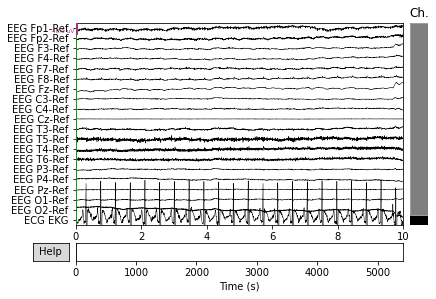

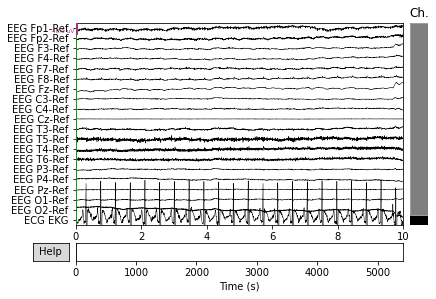

In [5]:
raw.plot()

In [6]:
print('The actual data is just a matrix array!\n\n {}\n'.format(raw.get_data()))

The actual data is just a matrix array!

 [[ -8.52886795e-06  -1.89021584e-05  -1.77309804e-05 ...,   4.00000000e-09
    4.00000000e-09   4.00000000e-09]
 [ -5.68457863e-06  -1.00346682e-05  -1.07039127e-05 ...,   4.00000000e-09
    4.00000000e-09   4.00000000e-09]
 [ -1.16717795e-06  -3.67684500e-06  -2.33835591e-06 ...,   4.00000000e-09
    4.00000000e-09   4.00000000e-09]
 ..., 
 [  3.18291159e-06   5.69257863e-06   3.51753386e-06 ...,   4.00000000e-09
    4.00000000e-09   4.00000000e-09]
 [  4.01946727e-06   1.15484684e-05   1.03772904e-05 ...,  -1.16717795e-06
    1.71311136e-07   1.67711136e-06]
 [  1.13811573e-05   1.60658691e-05   2.05832698e-05 ...,  -9.19811249e-06
    2.71084041e-05   6.45860986e-05]]



In [36]:
# ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=800)
# ica.fit(raw)
# ica.exclude = [1, 2]  # details on how we picked these are omitted here
# ica.plot_properties(raw, picks=ica.exclude)

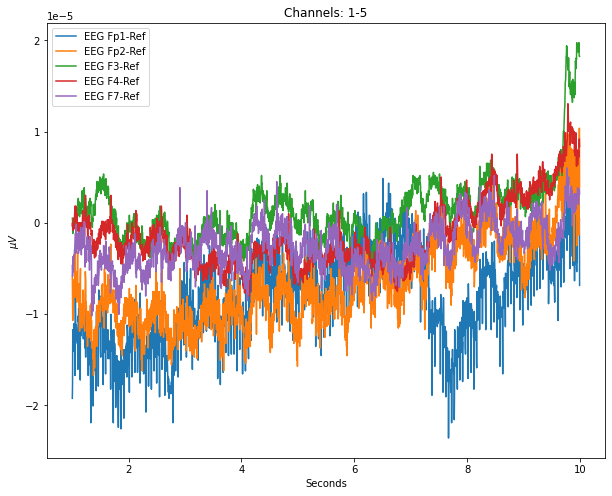

In [7]:
# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']
data, times = raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T);
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5')
plt.legend(raw.ch_names[:5])

In [8]:
# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

<RawEDF  |  eeg10.edf, n_channels x n_times : 21 x 1389312 (5427.0 sec), ~222.6 MB, data loaded>

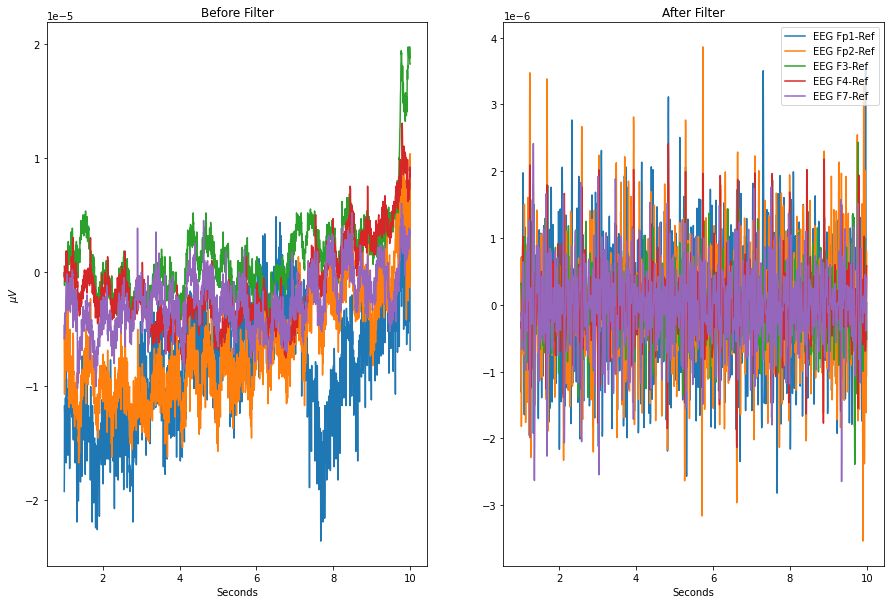

In [9]:
data_f, times_f = raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 10))

ax1.plot(times, data.T);
ax1.set_title('Before Filter')
ax1.set_xlabel('Seconds')
ax1.set_ylabel('$\mu V$')

ax2.plot(times_f, data_f.T);
ax2.set_title('After Filter')
ax2.set_xlabel('Seconds')

plt.legend(raw.ch_names[:5], loc=1);
# plt.tight_layout()

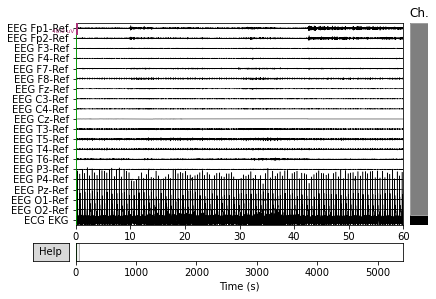

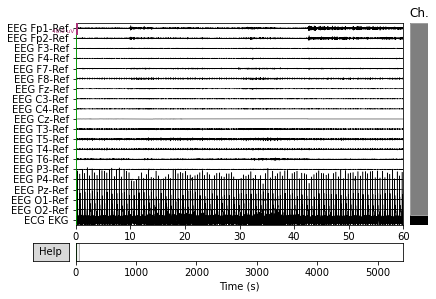

In [10]:
# %matplotlib qt
raw.plot(duration=60, block=True)

<ipython-input-11-bffe5ebb3400>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmax=np.inf, fmax=250)


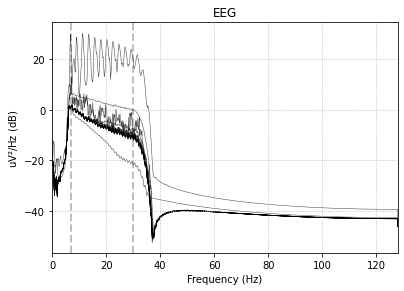

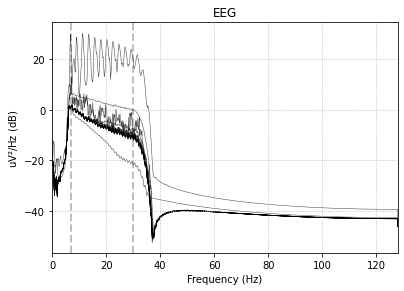

In [11]:
# %matplotlib qt
raw.plot_psd(tmax=np.inf, fmax=250)

In [12]:
raw_df = raw.to_data_frame()
raw_df.head()

Converting "time" to "<class 'numpy.int64'>"...


channel,EEG Fp1-Ref,EEG Fp2-Ref,EEG F3-Ref,EEG F4-Ref,EEG F7-Ref,EEG F8-Ref,EEG Fz-Ref,EEG C3-Ref,EEG C4-Ref,EEG Cz-Ref,...,EEG T5-Ref,EEG T4-Ref,EEG T6-Ref,EEG P3-Ref,EEG P4-Ref,EEG Pz-Ref,EEG O1-Ref,EEG O2-Ref,ECG EKG,Resp Effort
time,,,,,,,,,,,,,,,,,,,,,
0,8.735027e-16,-3.176374e-16,-1.230845e-15,-2.117582e-16,2.117582e-16,4.235165e-16,-1.879354e-15,-5.293956e-17,-9.529121e-16,3.044025e-16,...,-2.541099e-15,-1.482308e-15,-5.426305e-16,-6.882143e-16,-4.764560e-16,-7.808585e-16,4.235165e-16,6.088049e-16,-1.355253e-14,8.675470e-15
4,-3.576286e+00,-2.239225e+00,-6.406588e-01,-1.181933e+00,-1.661907e+00,-1.425307e+00,-1.972030e+00,7.948394e-03,-1.305807e-01,-6.120726e-02,...,1.976480e+00,-1.326910e+00,-1.625422e+00,-2.394817e-01,6.001104e-01,7.746496e-03,1.492466e-01,1.279110e-01,8.452432e-01,2.997113e+00
8,-6.287686e+00,-3.866624e+00,-1.088527e+00,-2.042460e+00,-2.849699e+00,-2.468875e+00,-3.427962e+00,-3.042047e-02,-1.932867e-01,-9.871177e-02,...,3.259740e+00,-2.388702e+00,-2.873590e+00,-4.373682e-01,9.969151e-01,-1.239143e-03,2.755995e-01,2.536193e-01,1.789794e+00,5.760376e+00
12,-7.615240e+00,-4.534088e+00,-1.230772e+00,-2.397414e+00,-3.280941e+00,-2.916921e+00,-4.055458e+00,-1.359542e-01,-1.626718e-01,-9.950038e-02,...,3.453460e+00,-3.010303e+00,-3.490885e+00,-5.611895e-01,1.067627e+00,-3.619767e-02,3.605522e-01,3.697844e-01,2.734882e+00,8.062733e+00
16,-7.559874e+00,-4.288425e+00,-1.074515e+00,-2.267528e+00,-2.966661e+00,-2.799580e+00,-3.851964e+00,-2.890417e-01,-7.083930e-02,-6.656181e-02,...,2.615986e+00,-3.156810e+00,-3.414905e+00,-5.944267e-01,8.158726e-01,-9.245718e-02,3.943869e-01,4.631228e-01,3.321237e+00,9.700623e+00


In [21]:
# NO STIM CHANNELS FOUND
# raw.copy().pick_types(meg=False, stim=True).plot(start=3, duration=6)
list_channels = raw.info['ch_names']

In [13]:
# for ch in list_channels:
#     print(ch)
#     events = mne.find_events(raw, stim_channel=ch)
#     print(events)
#     print("\n")

# THERE IS NO STIM CHANNEL